#Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
import numpy as np

## Get Train and Test data

In [4]:
def get_train_test():
    ##Train Phase transformations
    train_transforms = transforms.Compose([
        #  transforms.Resize((28, 28)),
        #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
        # Note the difference between (0.1307) and (0.1307,)
    ])

    ##Test Phase transformations
    test_transforms = transforms.Compose([
        #  transforms.Resize((28, 28)),
        #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    ##Dataset and creating train/test split
    train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
    test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

    ##Dataloader Arguments & Test/Train Dataloaders
    SEED = 1

    # CUDA?
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)

    # For reproducibility
    torch.manual_seed(SEED)

    if cuda:
        torch.cuda.manual_seed(SEED)

    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True,
                                                                                                          batch_size=64)

    # train dataloader
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

    # test dataloader
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

    return train_loader, test_loader, test


##Ghost Batch Normalisation Class

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
      try:
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)
      except Exception as e:
        raise Exception('GBN: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#Base Model

In [6]:
class Net(nn.Module):
    def __init__(self, requiredBN, requiredGBN):
        super(Net, self).__init__()
        self.requiredBN = requiredBN
        self.requiredGBN = requiredGBN

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN1 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN1 = GhostBatchNorm(num_features=10, num_splits=2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN2 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN2 = GhostBatchNorm(num_features=10, num_splits=2)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN3 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN3 = GhostBatchNorm(num_features=16, num_splits=2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN4 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN4 = GhostBatchNorm(num_features=16, num_splits=2)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN5 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN5 = GhostBatchNorm(num_features=16, num_splits=2)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN6 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN6 = GhostBatchNorm(num_features=10, num_splits=2)

        self.convblock7 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0)

    def forward(self, x):
      try:
        x = self.convblock1(x)
        if self.requiredBN is True:
            x = self.BN1(x)
        if self.requiredGBN is True:
            x = self.GBN1(x)

        x = self.convblock2(x)
        if self.requiredBN is True:
            x = self.BN2(x)
        if self.requiredGBN is True:
            x = self.GBN2(x)

        x = self.pool1(x)

        x = self.convblock3(x)
        if self.requiredBN is True:
            x = self.BN3(x)
        if self.requiredGBN is True:
            x = self.GBN3(x)

        x = self.convblock4(x)
        if self.requiredBN is True:
            x = self.BN4(x)
        if self.requiredGBN is True:
            x = self.GBN4(x)

        x = self.pool2(x)

        x = self.convblock5(x)
        if self.requiredBN is True:
            x = self.BN5(x)
        if self.requiredGBN is True:
            x = self.GBN5(x)

        x = self.convblock6(x)
        if self.requiredBN is True:
            x = self.BN6(x)
        if self.requiredGBN is True:
            x = self.GBN6(x)

        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
      except Exception as e:
        raise Exception('Base Model: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#L1 Regularization

In [7]:
def l1_regularization(model, factor=0.0005):
  try:
    # l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(param.abs()) #l1_crit(param)
    loss = factor * reg_loss
    
  except Exception as e:
        print('L1: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)
  return loss

# Training

In [8]:
def train(model, device, train_loader, optimizer, epoch, reg_l1=False, l1_lambda=0.0005):
    from tqdm import tqdm
    try:

      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      batch_train_losses = []
      batch_train_acc = []

      for batch_idx, (data, target) in enumerate(pbar):
          # get samples
          data, target = data.to(device), target.to(device)

          # Init
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
          # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

          # Predict
          y_pred = model(data)

          # Calculate loss
          loss = F.nll_loss(y_pred, target)
          # batch_train_losses.append(loss)

          # if chosed regularisation is L1
          if reg_l1 is True:
              loss = loss + l1_regularization(model, l1_lambda)
          batch_train_losses.append(loss)

          # Backpropagation
          loss.backward()
          optimizer.step()

          # Update pbar-tqdm
          pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)

          pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
          batch_train_acc.append(100 * correct / processed)

    except Exception as e:
      print('Train: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
      sys.exit(1)

    return batch_train_losses, batch_train_acc

##Testing

In [9]:
def test(model, device, test_loader):
  try:
    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    test_acc = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
  except Exception as e:
        print('Test: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

  return test_losses, test_acc

##Plotting Misclassified images for a model

In [10]:
def plot_misclassified_images(model, filename, device, test_loader,fig_title,batch_size):
  try:
    model = model.to(device)
    # obtain one batch of test images
    data_iterator = iter(test_loader)
    count = 0
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(fig_title, fontsize=18)
    while count < 25:
        images, labels = data_iterator.next()
        images, labels = images.to(device), labels.to(device)
        output = model(images)

        _, predictions = torch.max(output, 1)
        images = images.cpu().numpy()

        for idx in np.arange(batch_size):
            if predictions[idx] != labels[idx]:
                ax = fig.add_subplot(5, 5, count + 1, xticks=[], yticks=[])
                ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
                ax.set_title("Predicted-{},Actual-{}".format(str(predictions[idx].item()), str(labels[idx].item())),
                             color="black")

                count = count + 1
                if count == 25:
                    break
    print('\n\n\n\n')                
    plt.savefig(filename)
    plt.show()
  except Exception as e:
        print('Misclassification plot: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#Plotting Test Accuracies and Test Losses

In [11]:
# %matplotlib inline
def plot_acc_loss(test_losses, test_acc, num_conditions):
  """
  without L1/L2 with BN
  without L1/L2 with GBN
  with L1 with BN
  with L1 with GBN
  with L2 with BN
  with L2 with GBN
  with L1 and L2 with BN
  with L1 and L2 with GBN
  """
  try:
  
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Test Loss and Test Accuracy for the models', fontsize=16)
    for i in range(0, num_conditions):
        ax1.plot(test_losses[i])

    ax1.set_title("Test Loss")
    ax1.legend(['Without L1/L2 with BN','Without L1/L2 with GBN','L1 With BN','L1 With GBN','L2 With BN','L2 With GBN','L1 & L2 With BN','L1 & L2 With GBN'], loc='best')

    for i in range(0, num_conditions):
        ax2.plot(test_acc[i])

    ax2.set_title("Test Accuracy")
    ax2.legend(['Without L1/L2 with BN','Without L1/L2 with GBN','L1 With BN','L1 With GBN','L2 With BN','L2 With GBN','L1 & L2 With BN','L1 & L2 With GBN'], loc='best')

    plt.savefig('acc_vs_loss.jpg')
    plt.show()
  except Exception as e:
        print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

##Main function

In [12]:
def main(conditions):
    train_loader, test_loader, test_data = get_train_test()

    !pip install torchsummary
    from torchsummary import summary

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(device)

    EPOCHS = 25

    main_train_losses = []
    main_tr_acc = []
    main_test_losses = []
    main_test_acc = []

    # WEIGHT_DECAY=1e-5

    for i in range(1, len(conditions) + 1):
        train_losses = []
        tr_acc = []
        test_losses = []
        test_acc = []
        cond = conditions['cond' + str(i)]
        print('\n\t---------- ' + cond['condition'] + ' ----------\n')

        model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
        # print(summary(model, input_size=(1, 28, 28)))
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=cond['wt_decay'])

        for epoch in range(EPOCHS):
            print("EPOCH:", epoch)
            # batch_train_losses,batch_train_acc
            res_train_losses, res_train_acc = train(model, device, train_loader, optimizer, epoch,
                                                    reg_l1=cond['req_L1'], l1_lambda=0.0005)
            res_test_losses, res_test_acc = test(model, device, test_loader, )

            train_losses.append(res_train_losses)
            tr_acc.append(res_train_acc)
            test_losses.append(res_test_losses)
            test_acc.append(res_test_acc)

        main_train_losses.append(train_losses)
        main_tr_acc.append(tr_acc)
        main_test_losses.append(test_losses)
        main_test_acc.append(test_acc)

        # print('----------model'+str(i)+'-------------')
        # print(model)

        torch.save(model.state_dict(), 'model' + str(i) + '.pth')

    plot_acc_loss(main_test_losses, main_test_acc, len(conditions))

    # "without L1/L2 with BN"
    cond = conditions['cond1']
    sample_model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
    sample_model.load_state_dict(torch.load("model1.pth"))  # ,strict=False)

    plot_misclassified_images(sample_model, 'without_l1l2_with_bn.jpg', device, test_loader,fig_title='25 Misclassified images(model:without L1/L2 with BN)', batch_size=64)

    #"without L1/L2 with GBN"
    cond = conditions['cond2']
    sample_model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
    sample_model.load_state_dict(torch.load("model2.pth"))  # ,strict=False)

    plot_misclassified_images(sample_model, 'without_l1l2_with_gbn.jpg', device, test_loader,fig_title='25 Misclassified images(model:without L1/L2 with GBN)', batch_size=64)

##Calling main

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CUDA Available? True
cuda

	---------- without L1/L2 with BN ----------



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15739095211029053 Batch_id=937 Accuracy=94.44: 100%|██████████| 938/938 [00:11<00:00, 81.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9859/10000 (98.59%)

EPOCH: 1


Loss=0.013852343894541264 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:11<00:00, 84.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.24356751143932343 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:11<00:00, 82.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.0017395725008100271 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:11<00:00, 82.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.004564085975289345 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:11<00:00, 82.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.010041470639407635 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:11<00:00, 82.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.0665154680609703 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:11<00:00, 82.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.0015502098249271512 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:11<00:00, 83.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.07375606149435043 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:11<00:00, 83.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.0017320261104032397 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:11<00:00, 83.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.026749109849333763 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:11<00:00, 83.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.005223903339356184 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:11<00:00, 82.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.0038461158983409405 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:11<00:00, 83.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.04020623117685318 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:11<00:00, 84.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.04680413752794266 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:11<00:00, 84.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.015894265845417976 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:11<00:00, 84.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.05619435012340546 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:11<00:00, 84.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.09292386472225189 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:11<00:00, 83.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.03249487653374672 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:11<00:00, 83.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


Loss=0.00106225220952183 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:11<00:00, 81.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.017200633883476257 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:11<00:00, 83.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.002398927928879857 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:11<00:00, 84.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.004950452595949173 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:11<00:00, 84.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.00048163929022848606 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:11<00:00, 82.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.004508682526648045 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:11<00:00, 82.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)


	---------- without L1/L2 with GBN ----------

EPOCH: 0


Loss=0.04636967182159424 Batch_id=937 Accuracy=94.44: 100%|██████████| 938/938 [00:12<00:00, 77.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.011882795952260494 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:12<00:00, 77.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.024305198341608047 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:12<00:00, 77.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.007423317059874535 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:12<00:00, 77.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.057237353175878525 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:12<00:00, 77.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.001717397477477789 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:12<00:00, 78.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.09973028302192688 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:12<00:00, 77.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.011820446699857712 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:12<00:00, 77.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.0030700084753334522 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:11<00:00, 78.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.11794759333133698 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:12<00:00, 77.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.10215292125940323 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:12<00:00, 77.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.00984994601458311 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:12<00:00, 77.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.010827520862221718 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:12<00:00, 77.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.023359430953860283 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:12<00:00, 77.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.03254817798733711 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:12<00:00, 77.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.02381657250225544 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:12<00:00, 78.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.10000907629728317 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:12<00:00, 77.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.014907848089933395 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:12<00:00, 77.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.0051949648186564445 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:12<00:00, 75.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.008897342719137669 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:12<00:00, 76.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.0005007468280382454 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:11<00:00, 78.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.03031514771282673 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:12<00:00, 77.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.0018011840293183923 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:11<00:00, 78.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 23


Loss=0.0029703197069466114 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:12<00:00, 77.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.0010478157782927155 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:12<00:00, 76.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)


	---------- with L1 with BN ----------

EPOCH: 0


Loss=0.38645508885383606 Batch_id=937 Accuracy=94.14: 100%|██████████| 938/938 [00:13<00:00, 67.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.2803286612033844 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:13<00:00, 67.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.3724183738231659 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:13<00:00, 68.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.36003151535987854 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:13<00:00, 68.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.4243518114089966 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:13<00:00, 68.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9831/10000 (98.31%)

EPOCH: 5


Loss=0.2949729561805725 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:13<00:00, 67.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9843/10000 (98.43%)

EPOCH: 6


Loss=0.3980404734611511 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:13<00:00, 67.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.3014453053474426 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:13<00:00, 67.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.20588986575603485 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:13<00:00, 68.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9838/10000 (98.38%)

EPOCH: 9


Loss=0.4600380063056946 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:13<00:00, 68.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9868/10000 (98.68%)

EPOCH: 10


Loss=0.18135686218738556 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:13<00:00, 67.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9874/10000 (98.74%)

EPOCH: 11


Loss=0.1733155995607376 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:13<00:00, 67.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9827/10000 (98.27%)

EPOCH: 12


Loss=0.182823047041893 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:13<00:00, 67.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9879/10000 (98.79%)

EPOCH: 13


Loss=0.15739023685455322 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:13<00:00, 68.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.17976246774196625 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:13<00:00, 68.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9869/10000 (98.69%)

EPOCH: 15


Loss=0.17072361707687378 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:13<00:00, 67.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.16024073958396912 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:13<00:00, 67.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9875/10000 (98.75%)

EPOCH: 17


Loss=0.4169391989707947 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:13<00:00, 67.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9886/10000 (98.86%)

EPOCH: 18


Loss=0.24117641150951385 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:14<00:00, 66.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9867/10000 (98.67%)

EPOCH: 19


Loss=0.20973703265190125 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:14<00:00, 66.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9859/10000 (98.59%)

EPOCH: 20


Loss=0.1669864058494568 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:14<00:00, 66.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9878/10000 (98.78%)

EPOCH: 21


Loss=0.15207959711551666 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:13<00:00, 67.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9857/10000 (98.57%)

EPOCH: 22


Loss=0.15402668714523315 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:13<00:00, 67.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9784/10000 (97.84%)

EPOCH: 23


Loss=0.1633044183254242 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:13<00:00, 67.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9902/10000 (99.02%)

EPOCH: 24


Loss=0.22139373421669006 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:13<00:00, 69.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9858/10000 (98.58%)


	---------- with L1 with GBN ----------

EPOCH: 0


Loss=0.34437087178230286 Batch_id=937 Accuracy=93.82: 100%|██████████| 938/938 [00:14<00:00, 64.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.34622353315353394 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:14<00:00, 63.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.31366315484046936 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:14<00:00, 63.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.3036767840385437 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:14<00:00, 62.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.19570940732955933 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:14<00:00, 64.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.17652028799057007 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:14<00:00, 64.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.2256460189819336 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:14<00:00, 64.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.18489305675029755 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:14<00:00, 63.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9847/10000 (98.47%)

EPOCH: 8


Loss=0.462194561958313 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:14<00:00, 64.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9847/10000 (98.47%)

EPOCH: 9


Loss=0.3275580406188965 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:15<00:00, 62.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9833/10000 (98.33%)

EPOCH: 10


Loss=0.17665408551692963 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:14<00:00, 63.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.16179564595222473 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:14<00:00, 62.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9848/10000 (98.48%)

EPOCH: 12


Loss=0.20803901553153992 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:14<00:00, 62.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.2185647189617157 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:14<00:00, 63.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9864/10000 (98.64%)

EPOCH: 14


Loss=0.2378089874982834 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:14<00:00, 63.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9884/10000 (98.84%)

EPOCH: 15


Loss=0.19717060029506683 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:14<00:00, 64.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9872/10000 (98.72%)

EPOCH: 16


Loss=0.16615715622901917 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:14<00:00, 63.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9872/10000 (98.72%)

EPOCH: 17


Loss=0.22248530387878418 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:14<00:00, 63.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9837/10000 (98.37%)

EPOCH: 18


Loss=0.15214338898658752 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:14<00:00, 63.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9878/10000 (98.78%)

EPOCH: 19


Loss=0.19365084171295166 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:14<00:00, 63.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9821/10000 (98.21%)

EPOCH: 20


Loss=0.22134287655353546 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:14<00:00, 64.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0818, Accuracy: 9721/10000 (97.21%)

EPOCH: 21


Loss=0.32557448744773865 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:14<00:00, 63.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9825/10000 (98.25%)

EPOCH: 22


Loss=0.18551962077617645 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:14<00:00, 62.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9877/10000 (98.77%)

EPOCH: 23


Loss=0.15229813754558563 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:14<00:00, 63.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9872/10000 (98.72%)

EPOCH: 24


Loss=0.20011840760707855 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:14<00:00, 62.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9873/10000 (98.73%)


	---------- with L2 with BN ----------

EPOCH: 0


Loss=0.15428504347801208 Batch_id=937 Accuracy=93.65: 100%|██████████| 938/938 [00:11<00:00, 82.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9850/10000 (98.50%)

EPOCH: 1


Loss=0.035118039697408676 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:11<00:00, 81.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.057995542883872986 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:11<00:00, 81.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.006261107511818409 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:11<00:00, 81.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.02581506222486496 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:11<00:00, 78.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.0046916864812374115 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:11<00:00, 79.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.021422279998660088 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:11<00:00, 81.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.0017097173258662224 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:11<00:00, 80.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.013435907661914825 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:11<00:00, 79.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.028548533096909523 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:11<00:00, 81.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.0007811096147634089 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:11<00:00, 81.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.31926894187927246 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:11<00:00, 82.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.08564216643571854 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:11<00:00, 81.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.0029834676533937454 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:11<00:00, 81.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.16100604832172394 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:12<00:00, 78.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.013502320274710655 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:11<00:00, 80.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.016496730968356133 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:11<00:00, 81.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.04832809045910835 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:11<00:00, 81.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.1124868243932724 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:11<00:00, 81.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.026582295075058937 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:11<00:00, 80.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.0074813091196119785 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:11<00:00, 81.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.0025524909142404795 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:11<00:00, 80.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.10000389814376831 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:11<00:00, 81.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.1062355563044548 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:11<00:00, 81.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.06032976135611534 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:11<00:00, 79.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)


	---------- with L2 with GBN ----------

EPOCH: 0


Loss=0.2517741322517395 Batch_id=937 Accuracy=94.15: 100%|██████████| 938/938 [00:12<00:00, 76.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9850/10000 (98.50%)

EPOCH: 1


Loss=0.09820491820573807 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:12<00:00, 74.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.007491369266062975 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:12<00:00, 75.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.08257459849119186 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:12<00:00, 73.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.006183953024446964 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:12<00:00, 74.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.03744829446077347 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:12<00:00, 76.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.06393024325370789 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:12<00:00, 74.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.21582357585430145 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:12<00:00, 75.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.0032243479508906603 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:12<00:00, 74.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.01032952219247818 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:12<00:00, 75.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.20014740526676178 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:12<00:00, 73.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.01584210805594921 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:12<00:00, 76.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.017065873369574547 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:12<00:00, 75.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.062405724078416824 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:12<00:00, 75.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.17074483633041382 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:12<00:00, 74.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.004305062349885702 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:12<00:00, 75.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.002040162682533264 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:12<00:00, 75.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.11535273492336273 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:12<00:00, 73.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.04193686321377754 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:12<00:00, 75.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.03178679570555687 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:12<00:00, 74.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.01931728981435299 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:12<00:00, 74.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.047898076474666595 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:12<00:00, 75.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.011176565662026405 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:12<00:00, 76.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.009118856862187386 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:12<00:00, 75.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.04758775606751442 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:12<00:00, 74.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)


	---------- with L1 and L2 with BN ----------

EPOCH: 0


Loss=0.32087987661361694 Batch_id=937 Accuracy=94.61: 100%|██████████| 938/938 [00:14<00:00, 65.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.209777370095253 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:14<00:00, 66.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.26246875524520874 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:14<00:00, 66.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.2317304015159607 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:13<00:00, 67.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.3711628317832947 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:13<00:00, 67.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.2752808630466461 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:14<00:00, 65.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9821/10000 (98.21%)

EPOCH: 6


Loss=0.19303831458091736 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:14<00:00, 66.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.34869006276130676 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:14<00:00, 66.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9827/10000 (98.27%)

EPOCH: 8


Loss=0.18288913369178772 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:14<00:00, 66.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9861/10000 (98.61%)

EPOCH: 9


Loss=0.1782270073890686 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:13<00:00, 67.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.1659066081047058 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:13<00:00, 67.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9878/10000 (98.78%)

EPOCH: 11


Loss=0.2087002843618393 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:14<00:00, 65.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9823/10000 (98.23%)

EPOCH: 12


Loss=0.30048006772994995 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:14<00:00, 66.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9867/10000 (98.67%)

EPOCH: 13


Loss=0.24945998191833496 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:14<00:00, 66.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9804/10000 (98.04%)

EPOCH: 14


Loss=0.21606330573558807 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:14<00:00, 66.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9864/10000 (98.64%)

EPOCH: 15


Loss=0.19331450760364532 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:14<00:00, 66.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0827, Accuracy: 9748/10000 (97.48%)

EPOCH: 16


Loss=0.21106137335300446 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:14<00:00, 66.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9865/10000 (98.65%)

EPOCH: 17


Loss=0.18760225176811218 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:13<00:00, 67.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9832/10000 (98.32%)

EPOCH: 18


Loss=0.2128739356994629 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:14<00:00, 66.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9872/10000 (98.72%)

EPOCH: 19


Loss=0.16897426545619965 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:14<00:00, 66.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Loss=0.2694745659828186 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:14<00:00, 65.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9829/10000 (98.29%)

EPOCH: 21


Loss=0.1524094194173813 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:14<00:00, 65.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9886/10000 (98.86%)

EPOCH: 22


Loss=0.34685245156288147 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:14<00:00, 66.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9891/10000 (98.91%)

EPOCH: 23


Loss=0.2372448444366455 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:14<00:00, 65.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9863/10000 (98.63%)

EPOCH: 24


Loss=0.1589389443397522 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:14<00:00, 66.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9871/10000 (98.71%)


	---------- with L1 and L2 with GBN ----------

EPOCH: 0


Loss=0.40324026346206665 Batch_id=937 Accuracy=94.01: 100%|██████████| 938/938 [00:15<00:00, 61.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.5080506801605225 Batch_id=937 Accuracy=96.97: 100%|██████████| 938/938 [00:15<00:00, 62.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.43199747800827026 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:15<00:00, 62.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.2678130865097046 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:14<00:00, 62.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


Loss=0.26585662364959717 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:15<00:00, 62.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.1947745680809021 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:15<00:00, 62.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9839/10000 (98.39%)

EPOCH: 6


Loss=0.37045347690582275 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:15<00:00, 61.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.28754672408103943 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:14<00:00, 63.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.24832689762115479 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:15<00:00, 62.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.17189428210258484 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:15<00:00, 62.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.24957174062728882 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:15<00:00, 61.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.2569649815559387 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:15<00:00, 61.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9882/10000 (98.82%)

EPOCH: 12


Loss=0.15874868631362915 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:15<00:00, 61.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9856/10000 (98.56%)

EPOCH: 13


Loss=0.22448673844337463 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:15<00:00, 62.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9844/10000 (98.44%)

EPOCH: 14


Loss=0.16812673211097717 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:15<00:00, 61.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9887/10000 (98.87%)

EPOCH: 15


Loss=0.18175968527793884 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:15<00:00, 60.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9869/10000 (98.69%)

EPOCH: 16


Loss=0.17290650308132172 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:14<00:00, 62.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9848/10000 (98.48%)

EPOCH: 17


Loss=0.15904556214809418 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:15<00:00, 61.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9875/10000 (98.75%)

EPOCH: 18


Loss=0.1693490445613861 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:15<00:00, 61.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9849/10000 (98.49%)

EPOCH: 19


Loss=0.17708352208137512 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:15<00:00, 62.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9866/10000 (98.66%)

EPOCH: 20


Loss=0.15873530507087708 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:15<00:00, 61.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9849/10000 (98.49%)

EPOCH: 21


Loss=0.18522626161575317 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:15<00:00, 61.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9827/10000 (98.27%)

EPOCH: 22


Loss=0.22591564059257507 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:15<00:00, 62.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Accuracy: 9769/10000 (97.69%)

EPOCH: 23


Loss=0.42876720428466797 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:15<00:00, 62.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9885/10000 (98.85%)

EPOCH: 24


Loss=0.2241840809583664 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:15<00:00, 62.09it/s]



Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.82%)



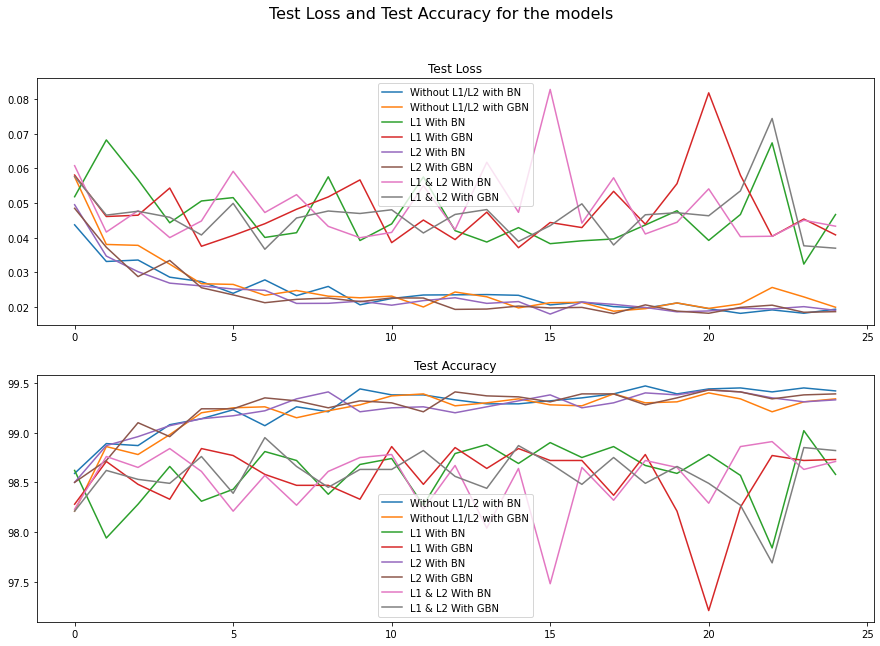

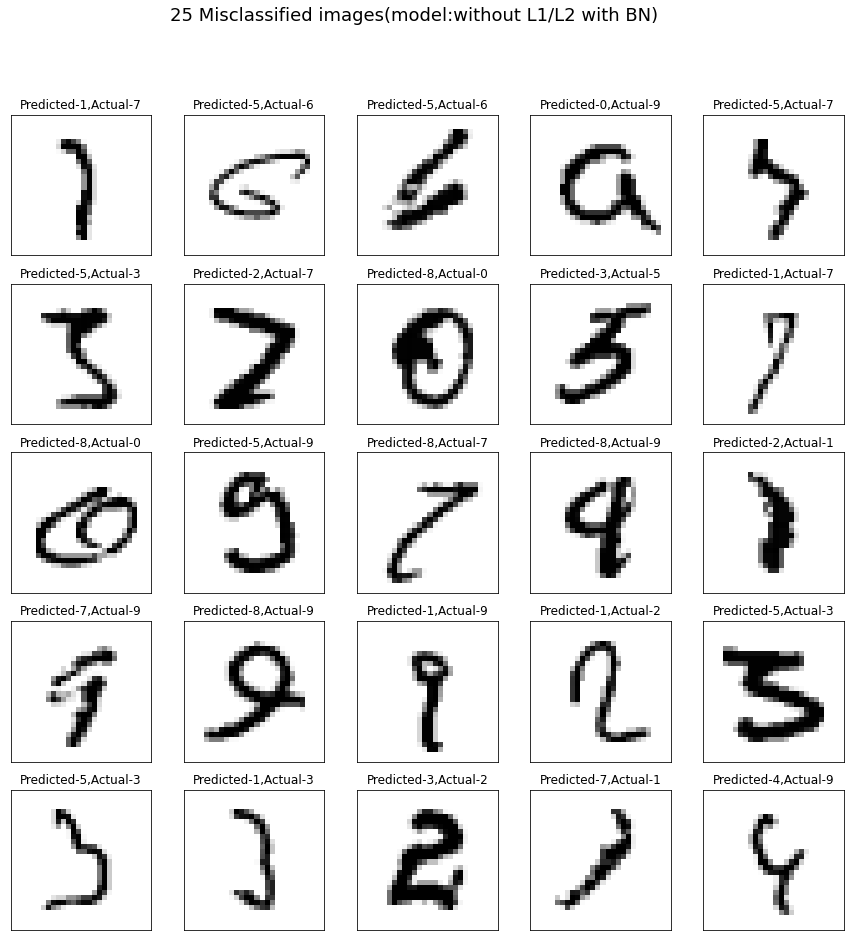

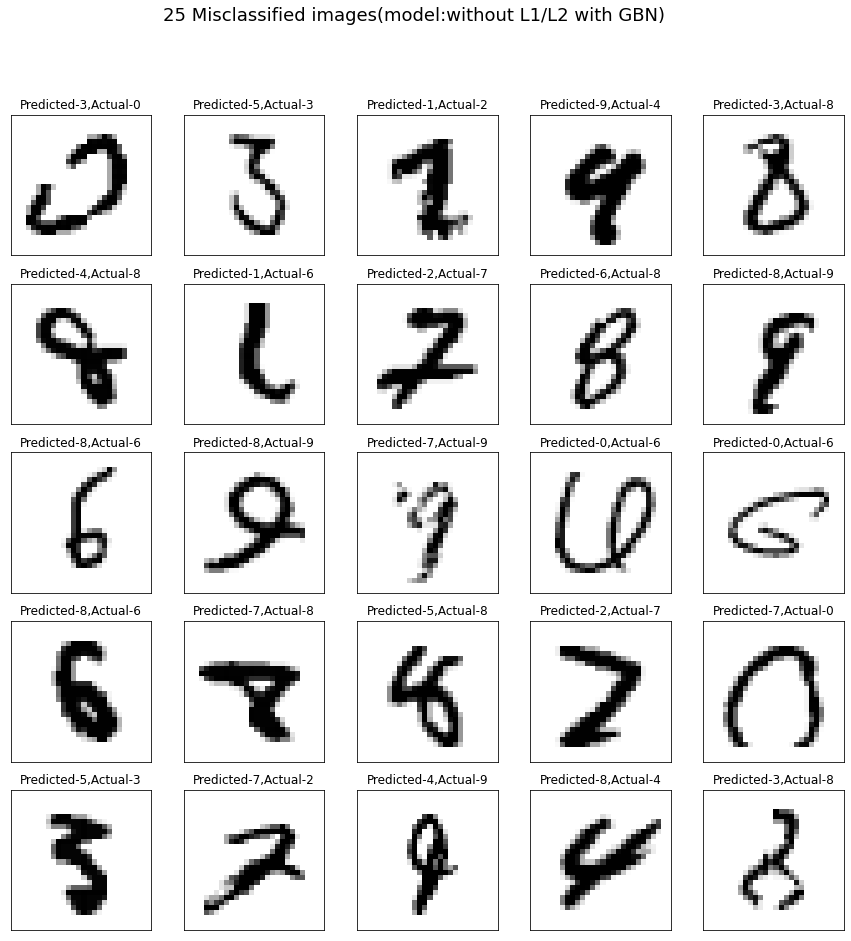

In [13]:
if __name__ == '__main__':
    """
    without L1/L2 with BN
    without L1/L2 with GBN
    with L1 with BN
    with L1 with GBN
    with L2 with BN
    with L2 with GBN
    with L1 and L2 with BN
    with L1 and L2 with GBN
    """

    conditions = {
        'cond1': {
            'condition': "without L1/L2 with BN",
            'req_L1': False,
            'req_L2': False,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond2': {
            'condition': "without L1/L2 with GBN",
            'req_L1': False,
            'req_L2': False,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond3': {
            'condition': "with L1 with BN",
            'req_L1': True,
            'req_L2': False,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond4': {
            'condition': 'with L1 with GBN',
            'req_L1': True,
            'req_L2': False,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond5': {
            'condition': 'with L2 with BN',
            'req_L1': False,
            'req_L2': True,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond6': {
            'condition': 'with L2 with GBN',
            'req_L1': False,
            'req_L2': True,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond7': {
            'condition': 'with L1 and L2 with BN',
            'req_L1': True,
            'req_L2': True,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond8': {
            'condition': 'with L1 and L2 with GBN',
            'req_L1': True,
            'req_L2': True,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        }
    }

    main(conditions)